Notebook for harry testing

In [135]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [136]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# Imports / Data etc
!wget -q https://github.com/tinchit0/la-quiniela/raw/refs/heads/main/laliga.sqlite -O laliga.db
warnings.filterwarnings("ignore")

conn = sqlite3.connect('laliga.db')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


Now need to clean the data and process into usable features.  
  
Firslty, dropping rows with no score and then splitting score into home and away component.  
  
I think it also makes sense to use the final notation suggested in the assignment of: home_win = 1, away_win = 2, tie = X  
  

In [137]:
df = df.dropna(axis = 'index' , how = 'any', subset = 'score')
df['season'] = df['season'].str[:4].astype(int)
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])
df = df[(~df['home_score'].isnull()) | (~df['away_score'].isnull())]

df['result'] = df.apply(lambda row: '1' if row['home_score'] > row['away_score']
                                        else '2' if row['home_score'] < row['away_score']
                                        else '0', axis=1)





In [138]:
# PERE Features

# Calculate home team total goals
home_goals = df.groupby('home_team')['home_score'].sum().reset_index()
home_goals.columns = ['team', 'home_goals']

# Calculate away team total goals
away_goals = df.groupby('away_team')['away_score'].sum().reset_index()
away_goals.columns = ['team', 'away_goals']

# Merge the home and away goals
all_time = pd.merge(home_goals, away_goals, on='team', how='outer').fillna(0)

# Calculate total goals
all_time['total_goals'] = all_time['home_goals'] + all_time['away_goals']

# Calculate total concedes when playing at home
home_conceding = df.groupby('home_team')['away_score'].sum().reset_index()
home_conceding.columns = ['team', 'concedes_home']

# Calculate total concedes when visiting
away_conceding = df.groupby('away_team')['home_score'].sum().reset_index()
away_conceding.columns = ['team', 'concedes_away']

# Calculate total concedes
all_time_concedes = pd.merge(home_conceding, away_conceding, on='team', how='outer').fillna(0)
all_time_concedes['total_concedes'] = all_time_concedes['concedes_home'] + all_time_concedes['concedes_away']
all_time = pd.merge(all_time, all_time_concedes, on='team', how='outer').fillna(0)

home_counts = df['home_team'].value_counts()
away_counts = df['away_team'].value_counts()
total_counts = home_counts.add(away_counts, fill_value=0)
df['home_app_home'] = df['home_team'].map(home_counts)
df['home_app_total'] = df['home_team'].map(total_counts)
df['away_app_away'] = df['away_team'].map(away_counts)
df['away_app_total'] = df['away_team'].map(total_counts)

df = df.merge(all_time[['team','home_goals','total_goals','concedes_home','total_concedes']], left_on='home_team', right_on='team', how='outer').fillna(0)
df = df.merge(all_time[['team','away_goals','total_goals','concedes_away','total_concedes']], left_on='away_team', right_on='team', suffixes=('_home', '_away'), how='outer').fillna(0)
df = df.drop('team_home', axis=1)
df = df.drop('team_away', axis=1)
df = df.sort_values(by='season', ascending=True)

df['home_goals_ratio'] = df['home_goals'] / df['home_app_home']
df['away_goals_ratio'] = df['away_goals'] / df['away_app_away']
df['total_goals_home_ratio'] = df['total_goals_home'] / df['home_app_total']
df['total_goals_away_ratio'] = df['total_goals_away'] / df['away_app_total']

df['concedes_home_ratio'] = df['concedes_home'] / df['home_app_home']
df['concedes_away_ratio'] = df['concedes_away'] / df['away_app_away']
df['total_concedes_home_ratio'] = df['total_concedes_home'] / df['home_app_total']
df['total_concedes_away_ratio'] = df['total_concedes_away'] / df['away_app_total']

#df = df.drop('home_app_home', axis=1)
#df = df.drop('home_app_total', axis=1)
#df = df.drop('away_app_away', axis=1)
#df = df.drop('away_app_total', axis=1)

df['goal_diff_home'] = df['home_goals'] - df['concedes_home']
df['goal_diff_home_total'] = df['total_goals_home'] - df['total_concedes_home']
df['goal_diff_away'] = df['away_goals'] - df['concedes_away']
df['goal_diff_away_total'] = df['total_goals_away'] - df['total_concedes_away']
df['goal_diff_home_ratio'] = df['home_goals_ratio'] - df['concedes_home_ratio']
df['goal_diff_home_total_ratio'] = df['total_goals_home_ratio'] - df['total_concedes_home_ratio']
df['goal_diff_away_ratio'] = df['away_goals_ratio'] - df['concedes_away_ratio']
df['goal_diff_away_total_ratio'] = df['total_goals_away_ratio'] - df['total_concedes_away_ratio']

-goals scores (at home and away)  
-goals conceded (at home and away)  
-goal difference  
-current ranking  
-average ranking in the last 5 seasons for example  
-current streak of games (average number of points gained in the last X games)  
-head2head (goals scored, conceded, wins, ties...)  
-general win/tie/loses rate of each team  
-Number of promotions and relegations ?  
-biggest win ?  
-longest undefeated streak ?  
-day and hour ?  

In [139]:
df['gd_5_game_home'] = None
df['gd_5_game_away'] = None
df['form_10_game_home'] = None
df['form_10_game_away'] = None

df['live_rank_home'] = None
df['live_rank_away'] = None

def calculate_gd_5_game(df):
    teams = df['home_team'].unique()
    for team in teams:
        team_df = df[(df['home_team'] == team) | (df['away_team'] == team)].copy()
        team_df['goal_difference'] = team_df.apply(
            lambda x: x['home_score'] - x['away_score'] if x['home_team'] == team else x['away_score'] - x['home_score'], axis=1
        )
        team_df['gd_5_game'] = team_df['goal_difference'].rolling(window=5).sum().shift(1)
        
        # Assign gd_5_game to the appropriate column based on home or away
        df.loc[team_df[team_df['home_team'] == team].index, 'gd_5_game_home'] = team_df.loc[team_df['home_team'] == team, 'gd_5_game']
        df.loc[team_df[team_df['away_team'] == team].index, 'gd_5_game_away'] = team_df.loc[team_df['away_team'] == team, 'gd_5_game']
    
    return df

def calculate_form_10_game(df):
    teams = df['home_team'].unique()
    for team in teams:
        team_df = df[(df['home_team'] == team) | (df['away_team'] == team)].copy()
        team_df['win'] = team_df.apply(
            lambda x: 1 if (x['home_team'] == team and x['home_score'] > x['away_score']) or 
                           (x['away_team'] == team and x['away_score'] > x['home_score']) else 0, axis=1
        )
        team_df['form_10_game'] = team_df['win'].rolling(window=10).sum().shift(1)
        
        # Assign form_10_game to the appropriate column based on home or away
        df.loc[team_df[team_df['home_team'] == team].index, 'form_10_game_home'] = team_df.loc[team_df['home_team'] == team, 'form_10_game']
        df.loc[team_df[team_df['away_team'] == team].index, 'form_10_game_away'] = team_df.loc[team_df['away_team'] == team, 'form_10_game']
    
    return df

# THIS FUNCTION NEEDS WORK
def calculate_live_rank(df):
    teams = df['home_team'].unique()
    points_table = {team: 0 for team in teams}
    matchdays = sorted(df['matchday'].unique())
    
    for matchday in matchdays:
        day_df = df[df['matchday'] == matchday]
        for _, row in day_df.iterrows():
            home_team, away_team = row['home_team'], row['away_team']
            home_score, away_score = row['home_score'], row['away_score']
            
            # Update points based on match result
            if home_score > away_score:
                points_table[home_team] += 3
            elif away_score > home_score:
                points_table[away_team] += 3
            else:
                points_table[home_team] += 1
                points_table[away_team] += 1
        
        # Sort teams by points and assign ranks
        sorted_teams = sorted(points_table.items(), key=lambda x: x[1], reverse=True)
        rank_dict = {team: rank+1 for rank, (team, _) in enumerate(sorted_teams)}
        
        # Update live rank for this matchday for both home and away teams
        for _, row in day_df.iterrows():
            df.loc[row.name, 'live_rank_home'] = rank_dict[row['home_team']]
            df.loc[row.name, 'live_rank_away'] = rank_dict[row['away_team']]
    
    return df


df = calculate_gd_5_game(df)
df = calculate_form_10_game(df)
df = calculate_live_rank(df)


display(df.head())
display(df.tail())


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away
27023,1928,1,9,4/21/29,0,Arenas Club,Racing,2:1,2,1,...,0.666667,-0.655556,-0.986822,-0.159302,NaN,NaN,NaN,NaN,62,9
1595,1928,1,15,6/2/29,0,Donostia,Arenas Club,3:2,3,2,...,1.092308,-0.315385,-1.977778,-0.655556,NaN,NaN,NaN,NaN,72,64
18170,1928,1,9,4/21/29,0,Catalunya,Donostia,4:3,4,3,...,0.370370,-0.629630,-1.723077,-0.315385,NaN,NaN,NaN,NaN,114,70
18173,1928,1,13,5/26/29,0,Espanyol,Donostia,1:1,1,1,...,0.764014,-0.070564,-1.723077,-0.315385,NaN,NaN,NaN,NaN,7,74
1575,1928,1,10,4/28/29,0,Athletic Madrid,Arenas Club,1:2,1,2,...,0.938776,-0.326531,-1.977778,-0.655556,NaN,NaN,NaN,NaN,88,62


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away
34479,2021,1,1,8/15/21,8:00 PM,Barcelona,Real Sociedad,4:2,4,2,...,1.854010,1.031196,-0.678886,0.123488,3.0,1.0,5.0,5.0,1,12
23952,2021,1,1,8/14/21,7:30 PM,Cádiz CF,Levante,1:1,1,1,...,0.389771,-0.195767,-0.696721,-0.159967,-4.0,-1.0,2.0,2.0,34,36
12309,2021,2,3,8/28/21,7:30 PM,Real Oviedo,CD Tenerife,0:0,0,0,...,0.776047,-0.046761,-0.619551,-0.055519,-4.0,0.0,1.0,2.0,16,24
21400,2021,1,1,8/13/21,9:00 PM,Valencia,Getafe,1:0,1,0,...,1.184358,0.348236,-0.583162,-0.169579,1.0,0.0,3.0,3.0,3,44
22581,2021,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0,4,0,...,0.516204,-0.085020,-1.135823,-0.259133,-6.0,0.0,4.0,4.0,18,32


In [140]:
df['prev_season_rank_home'] = None
df['prev_season_rank_away'] = None

def calculate_season_ranks(df):

    prev_season_ranks = {}

    seasons = df['season'].unique()
    for season in seasons:

        season_df = df[df['season'] == season].copy()

        points_table = {}

        for _, row in season_df.iterrows():
            home_team, away_team = row['home_team'], row['away_team']
            home_score, away_score = row['home_score'], row['away_score']

            if home_team not in points_table:
                points_table[home_team] = 0
            if away_team not in points_table:
                points_table[away_team] = 0

            if home_score > away_score:
                points_table[home_team] += 3
            elif away_score > home_score:
                points_table[away_team] += 3
            else:
                points_table[home_team] += 1
                points_table[away_team] += 1

        ranked_teams = sorted(points_table.items(), key=lambda x: x[1], reverse=True)
        season_ranking = {team: rank+1 for rank, (team, _) in enumerate(ranked_teams)}

        for team, rank in season_ranking.items():
            prev_season_ranks[(season, team)] = rank
    
    return prev_season_ranks

prev_season_ranks = calculate_season_ranks(df)


def assign_prev_season_rank(df, prev_season_ranks):

    for i, row in df.iterrows():
        current_season = row['season']
        home_team = row['home_team']
        away_team = row['away_team']

        prev_season_year = current_season - 1

        df.at[i, 'prev_season_rank_home'] = prev_season_ranks.get((prev_season_year, home_team), None)
        df.at[i, 'prev_season_rank_away'] = prev_season_ranks.get((prev_season_year, away_team), None)
    
    return df

df = assign_prev_season_rank(df, prev_season_ranks)

display(df[['season', 'home_team', 'away_team', 'prev_season_rank_home', 'prev_season_rank_away']].head())
display(df.tail())


,season,home_team,away_team,prev_season_rank_home,prev_season_rank_away
27023,1928,Arenas Club,Racing,None,None
1595,1928,Donostia,Arenas Club,None,None
18170,1928,Catalunya,Donostia,None,None
18173,1928,Espanyol,Donostia,None,None
1575,1928,Athletic Madrid,Arenas Club,None,None


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,goal_diff_away_ratio,goal_diff_away_total_ratio,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away,prev_season_rank_home,prev_season_rank_away
34479,2021,1,1,8/15/21,8:00 PM,Barcelona,Real Sociedad,4:2,4,2,...,-0.678886,0.123488,3.0,1.0,5.0,5.0,1,12,5,12
23952,2021,1,1,8/14/21,7:30 PM,Cádiz CF,Levante,1:1,1,1,...,-0.696721,-0.159967,-4.0,-1.0,2.0,2.0,34,36,30,35
12309,2021,2,3,8/28/21,7:30 PM,Real Oviedo,CD Tenerife,0:0,0,0,...,-0.619551,-0.055519,-4.0,0.0,1.0,2.0,16,24,21,22
21400,2021,1,1,8/13/21,9:00 PM,Valencia,Getafe,1:0,1,0,...,-0.583162,-0.169579,1.0,0.0,3.0,3.0,3,44,33,36
22581,2021,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0,4,0,...,-1.135823,-0.259133,-6.0,0.0,4.0,4.0,18,32,10,28


In [141]:
y = df.loc[:,'result']

cols_to_drop = ['score','home_score','away_score','result', 'home_team', 'away_team']
X = df.drop(columns=cols_to_drop)
X = X.drop(columns=['date', 'time'])
print(X.columns)
y[:10,]

Index(['season', 'division', 'matchday', 'home_app_home', 'home_app_total',
       'away_app_away', 'away_app_total', 'home_goals', 'total_goals_home',
       'concedes_home', 'total_concedes_home', 'away_goals',
       'total_goals_away', 'concedes_away', 'total_concedes_away',
       'home_goals_ratio', 'away_goals_ratio', 'total_goals_home_ratio',
       'total_goals_away_ratio', 'concedes_home_ratio', 'concedes_away_ratio',
       'total_concedes_home_ratio', 'total_concedes_away_ratio',
       'goal_diff_home', 'goal_diff_home_total', 'goal_diff_away',
       'goal_diff_away_total', 'goal_diff_home_ratio',
       'goal_diff_home_total_ratio', 'goal_diff_away_ratio',
       'goal_diff_away_total_ratio', 'gd_5_game_home', 'gd_5_game_away',
       'form_10_game_home', 'form_10_game_away', 'live_rank_home',
       'live_rank_away', 'prev_season_rank_home', 'prev_season_rank_away'],
      dtype='object')


27023    1
1595     1
18170    1
18173    0
1575     2
18146    1
35656    1
31565    1
35661    1
35618    1
Name: result, dtype: object

In [142]:
X.corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,season,division,matchday,home_app_home,home_app_total,away_app_away,away_app_total,home_goals,total_goals_home,concedes_home,total_concedes_home,away_goals,total_goals_away,concedes_away,total_concedes_away,home_goals_ratio,away_goals_ratio,total_goals_home_ratio,total_goals_away_ratio,concedes_home_ratio,concedes_away_ratio,total_concedes_home_ratio,total_concedes_away_ratio,goal_diff_home,goal_diff_home_total,goal_diff_away,goal_diff_away_total,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,gd_5_game_home,gd_5_game_away,form_10_game_home,form_10_game_away,live_rank_home,live_rank_away,prev_season_rank_home,prev_season_rank_away
season,1.000000,0.166222,0.215440,-0.109717,-0.109736,-0.109828,-0.109810,-0.150582,-0.141372,-0.107113,-0.127220,-0.124431,-0.141333,-0.138173,-0.127310,-0.332353,-0.106850,-0.266581,-0.266376,-0.063132,-0.379307,-0.318693,-0.318700,-0.165394,-0.100045,0.083534,-0.099829,-0.296526,-0.060412,0.218348,-0.060319,-0.009393,0.008176,-0.096525,-0.100266,0.061516,0.060181,0.308249,0.308204
division,0.166222,1.000000,0.090943,-0.582116,-0.582144,-0.582147,-0.582119,-0.579332,-0.578211,-0.567267,-0.561450,-0.573865,-0.578199,-0.555814,-0.561429,-0.431802,-0.398278,-0.439732,-0.439779,0.118829,0.035235,0.066705,0.066880,-0.535051,-0.345329,0.226944,-0.345373,-0.441094,-0.407500,-0.243355,-0.407541,0.031414,-0.060395,-0.047911,-0.118715,0.519401,0.518123,0.274777,0.274987
matchday,0.215440,0.090943,1.000000,-0.051647,-0.051653,-0.053961,-0.053953,-0.062079,-0.060027,-0.050582,-0.054492,-0.058420,-0.062330,-0.058898,-0.056924,-0.101582,-0.052734,-0.087895,-0.089974,-0.019990,-0.088593,-0.075530,-0.076524,-0.063994,-0.041743,0.027605,-0.042816,-0.090438,-0.035273,0.035818,-0.036536,0.007126,-0.007292,-0.021580,-0.042235,0.031585,0.029544,0.077179,0.080351
home_app_home,-0.109717,-0.582116,-0.051647,1.000000,0.999999,0.322954,0.322947,0.949933,0.947277,0.991148,0.984883,0.315601,0.318033,0.309406,0.312172,0.585685,0.212805,0.595862,0.236722,-0.252397,-0.019200,-0.182962,-0.038565,0.837516,0.464713,-0.132067,0.184747,0.623648,0.600294,0.130300,0.220701,0.145456,0.025670,0.202688,0.061816,-0.890583,-0.288028,-0.239496,-0.164421
home_app_total,-0.109736,-0.582144,-0.051653,0.999999,1.000000,0.322963,0.322955,0.950017,0.947368,0.991143,0.984866,0.315606,0.318038,0.309415,0.312180,0.585830,0.212807,0.596033,0.236727,-0.252412,-0.019196,-0.183008,-0.038560,0.837649,0.464931,-0.132076,0.184746,0.623789,0.600462,0.130299,0.220703,0.145514,0.025675,0.202751,0.061818,-0.890575,-0.288035,-0.239556,-0.164425
away_app_away,-0.109828,-0.582147,-0.053961,0.322954,0.322963,1.000000,0.999999,0.318653,0.318011,0.314769,0.312205,0.938929,0.947455,0.977221,0.984848,0.233153,0.538852,0.236597,0.596252,-0.071462,-0.127316,-0.038392,-0.183380,0.292500,0.184630,-0.503178,0.465215,0.240199,0.220555,0.387355,0.600683,-0.023800,0.265724,0.020971,0.289332,-0.289443,-0.889610,-0.164222,-0.239708
away_app_total,-0.109810,-0.582119,-0.053953,0.322947,0.322955,0.999999,1.000000,0.318647,0.318006,0.314761,0.312197,0.938825,0.947364,0.977246,0.984865,0.233148,0.538652,0.236593,0.596082,-0.071466,-0.127263,-0.038396,-0.183334,0.292496,0.184632,-0.503380,0.464997,0.240196,0.220554,0.387207,0.600515,-0.023795,0.265665,0.020971,0.289260,-0.289436,-0.889619,-0.164219,-0.239649
home_goals,-0.150582,-0.579332,-0.062079,0.949933,0.950017,0.318653,0.318647,1.000000,0.999175,0.915694,0.900310,0.307704,0.311195,0.309146,0.311022,0.762711,0.204484,0.783211,0.236083,-0.280986,0.006933,-0.223097,-0.013766,0.964993,0.705294,-0.143308,0.172139,0.798888,0.779999,0.106686,0.207282,0.213873,0.024650,0.277514,0.064531,-0.805436,-0.283876,-0.334878,-0.165345
total_goals_home,-0.141372,-0.578211,-0.060027,0.947277,0.947368,0.318011,0.318006,0.999175,1.000000,0.910894,0.893687,0.306569,0.309981,0.308353,0.310324,0.759620,0.203147,0.786215,0.233053,-0.288131,0.002834,-0.239812,-0.017041,0.966837,0.717313,-0.143455,0.17066

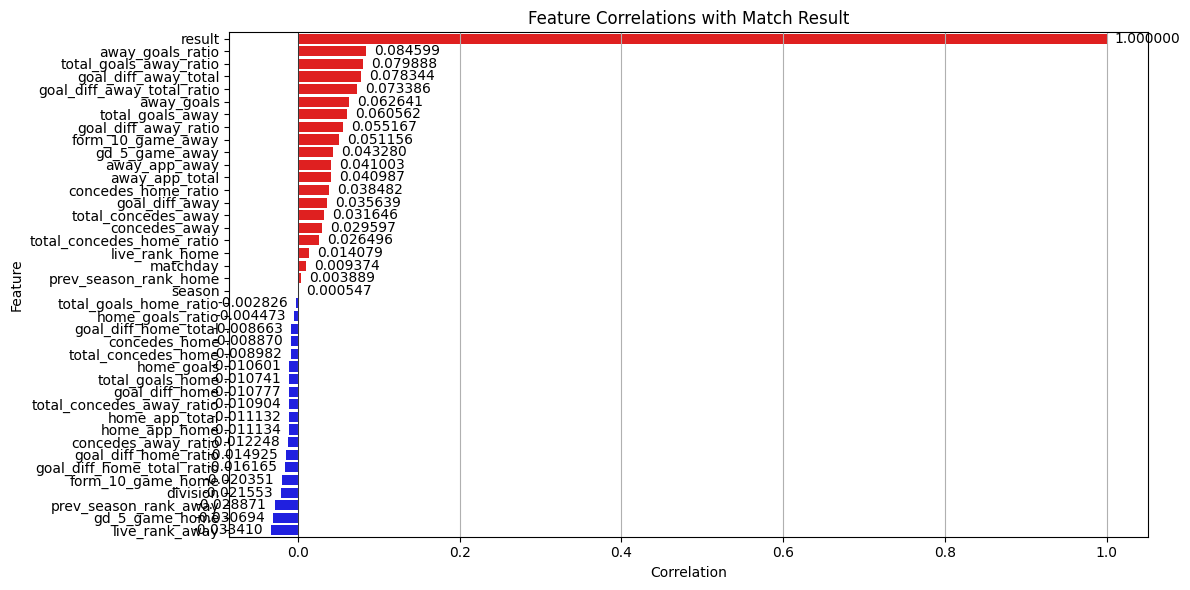


Correlations with match result:
                   Feature  Correlation
                    result     1.000000
          away_goals_ratio     0.084599
    total_goals_away_ratio     0.079888
      goal_diff_away_total     0.078344
goal_diff_away_total_ratio     0.073386
                away_goals     0.062641
          total_goals_away     0.060562
      goal_diff_away_ratio     0.055167
         form_10_game_away     0.051156
            gd_5_game_away     0.043280
             away_app_away     0.041003
            away_app_total     0.040987
       concedes_home_ratio     0.038482
            goal_diff_away     0.035639
       total_concedes_away     0.031646
             concedes_away     0.029597
 total_concedes_home_ratio     0.026496
            live_rank_home     0.014079
                  matchday     0.009374
     prev_season_rank_home     0.003889
                    season     0.000547
    total_goals_home_ratio    -0.002826
          home_goals_ratio    -0.004473
      g

In [143]:
cols_to_drop = ['date', 'time', 'score','home_score','away_score', 'home_team', 'away_team']
X = df.drop(columns=cols_to_drop)
X['result'] = pd.to_numeric(X['result'])

# Calculate correlations with result
correlations = X.corr()['result'].sort_values(ascending=False)

# Create a DataFrame for visualization
corr_df = pd.DataFrame({'Feature': correlations.index, 
                       'Correlation': correlations.values})

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=corr_df, 
            y='Feature',
            x='Correlation',
            palette=['red' if x > 0 else 'blue' for x in corr_df['Correlation']])

plt.title('Feature Correlations with Match Result')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, axis='x')

# Add correlation values on the bars
for i, v in enumerate(corr_df['Correlation']):
    plt.text(v + (0.01 if v >= 0 else -0.01), 
             i,
             f'{v:.6f}',
             va='center',
             ha='left' if v >= 0 else 'right')

plt.tight_layout()
plt.show()

# Print correlations in order
print("\nCorrelations with match result:")
print(corr_df.to_string(index=False))

# Optional: Calculate feature importance using absolute values
print("\nFeature importance (by absolute correlation):")
importance_df = corr_df.copy()
importance_df['Absolute Correlation'] = abs(importance_df['Correlation'])
importance_df = importance_df.sort_values('Absolute Correlation', ascending=False)
print(importance_df.to_string(index=False))

              precision    recall  f1-score   support

           0       0.40      0.02      0.04      2477
           1       0.55      0.96      0.70      5085
           2       0.44      0.15      0.23      2038

    accuracy                           0.54      9600
   macro avg       0.47      0.38      0.32      9600
weighted avg       0.49      0.54      0.43      9600



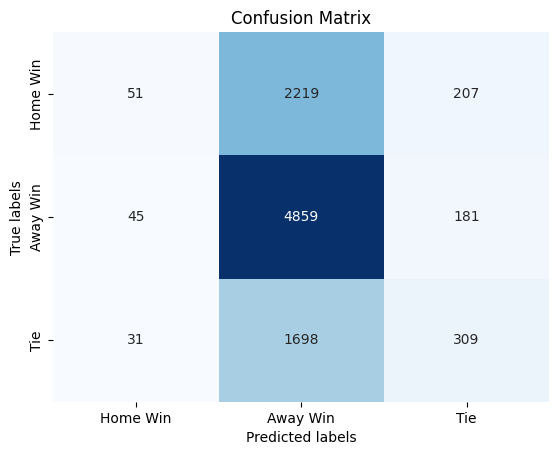

In [144]:
#X = pd.get_dummies(X, columns=['home_team','away_team'])
X = X.drop(columns = ['result'])
X = X.replace(np.nan, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
models_performance = pd.DataFrame(columns=['model', 'accuracy'])

def performance(y_test, y_pred, model):
    # Classificatin Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    accuracy = class_report['accuracy']

    # Plot Confusion Matrix
    labels = ["Home Win", "Away Win", "Tie"]
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = performance(y_test, gb_pred, gb_model)
models_performance.loc[len(models_performance)] = ['Gradient Boosting', gb_accuracy]

              precision    recall  f1-score   support

           0       0.12      0.00      0.00      2477
           1       0.54      0.97      0.70      5085
           2       0.44      0.11      0.18      2038

    accuracy                           0.54      9600
   macro avg       0.37      0.36      0.29      9600
weighted avg       0.41      0.54      0.41      9600



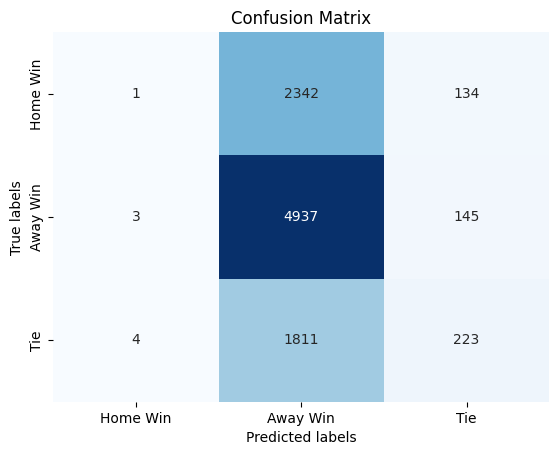

In [145]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
LR_accuracy = performance(y_test, LR_pred, LR_model)
models_performance.loc[len(models_performance)] = ['Logistic Regression', LR_accuracy]

              precision    recall  f1-score   support

           0       0.29      0.55      0.38      2477
           1       0.66      0.44      0.53      5085
           2       0.34      0.26      0.30      2038

    accuracy                           0.43      9600
   macro avg       0.43      0.42      0.40      9600
weighted avg       0.50      0.43      0.44      9600



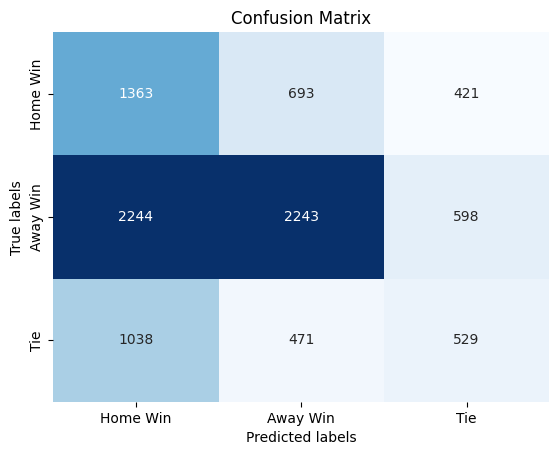

In [146]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
NB_pred = NB_model.predict(X_test)
NB_accuracy = performance(y_test, NB_pred, NB_model)
models_performance.loc[len(models_performance)] = ['Naive Bayes', NB_accuracy]

              precision    recall  f1-score   support

           0       0.29      0.31      0.30      2477
           1       0.57      0.69      0.62      5085
           2       0.30      0.13      0.18      2038

    accuracy                           0.47      9600
   macro avg       0.39      0.38      0.37      9600
weighted avg       0.44      0.47      0.45      9600



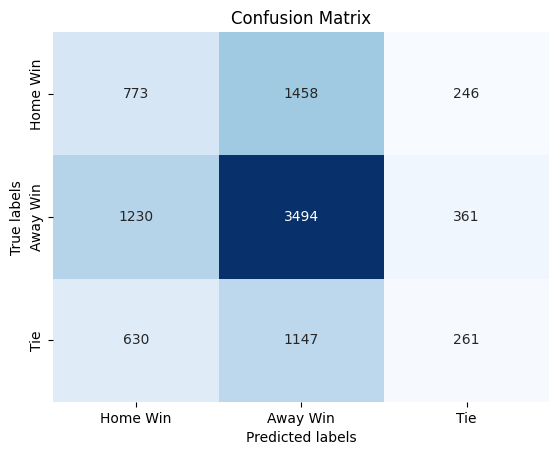

In [147]:
kNN_model = KNeighborsClassifier()
kNN_model.fit(X_train, y_train)
kNN_pred = kNN_model.predict(X_test)
kNN_accuracy = performance(y_test, kNN_pred, kNN_model)
models_performance.loc[len(models_performance)] = ['k Nearest Neighbors', kNN_accuracy]

              precision    recall  f1-score   support

           0       0.27      0.28      0.27      2477
           1       0.57      0.55      0.56      5085
           2       0.25      0.27      0.26      2038

    accuracy                           0.42      9600
   macro avg       0.36      0.37      0.36      9600
weighted avg       0.43      0.42      0.42      9600



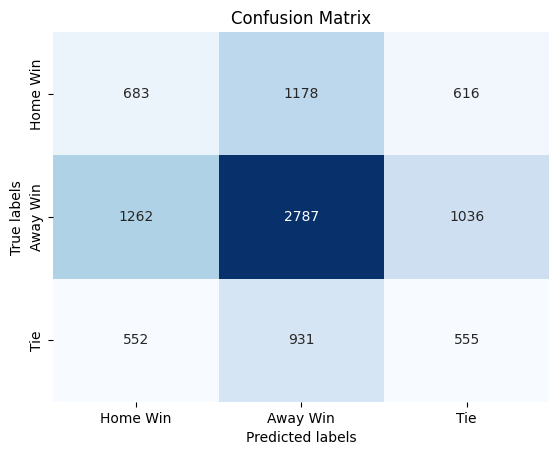

In [148]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_accuracy = performance(y_test, tree_pred, tree_model)
models_performance.loc[len(models_performance)] = ['Decision Trees', tree_accuracy]

              precision    recall  f1-score   support

           0       0.30      0.15      0.20      2477
           1       0.57      0.82      0.67      5085
           2       0.36      0.18      0.24      2038

    accuracy                           0.51      9600
   macro avg       0.41      0.38      0.37      9600
weighted avg       0.45      0.51      0.46      9600



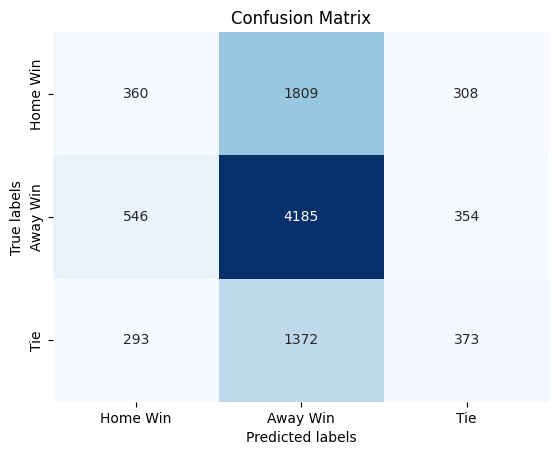

In [149]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_accuracy = performance(y_test, RF_pred, RF_model)
models_performance.loc[len(models_performance)] = ['Random Forest', RF_accuracy]

In [150]:
models_performance = models_performance.sort_values(['accuracy'], ascending=False)
print(models_performance)

                 model  accuracy
0    Gradient Boosting  0.543646
1  Logistic Regression  0.537604
5        Random Forest  0.512292
3  k Nearest Neighbors  0.471667
2          Naive Bayes  0.430729
4       Decision Trees  0.419271


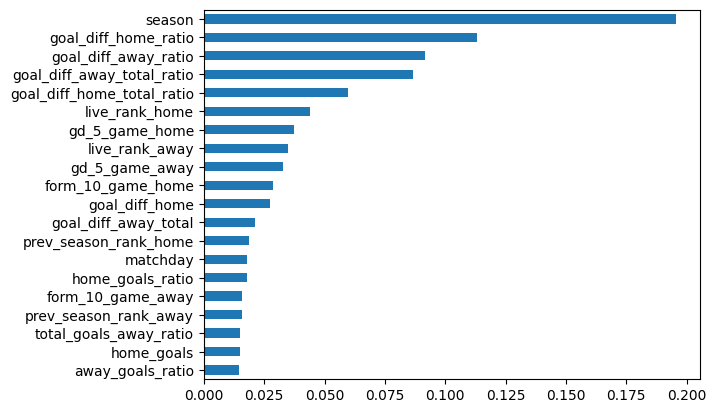

In [151]:
# Get the feature importance of the model
feature_imp = gb_model.feature_importances_

# Get the top 20 features
indices = np.argsort(feature_imp)[-20:][::-1]
feature_names = X.columns
feature_names = feature_names[indices]

# Plot
importances = pd.Series(feature_imp[indices], index=feature_names)
importances.sort_values(ascending=True).plot(kind="barh")
plt.show()